## Inferelator.R ported to python

In [153]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from scipy.stats import nbinom
import seaborn
import datetime
import os
import random

In [154]:
proc_time = datetime.datetime.now()

In [155]:
print proc_time.date()

2016-06-13


In [156]:
def intersect(a, b):
    return list(set(a) & set(b))

In [157]:
PARS = {}

In [158]:
PARS['input.dir'] = 'input/bsubtilis'
PARS['exp.mat.file'] = 'expression.tsv'
PARS['tf.names.file'] = 'tf_names.tsv'
PARS['meta.data.file'] = 'meta_data.tsv'
PARS['priors.file'] = None # 'gold_standard.tsv'
PARS['gold.standard.file'] = None
PARS['leave.out.file'] = None
PARS['randomize.expression'] = False
PARS['job.seed'] = 42  # set to None if a random seed should be used
PARS['save.to.dir'] = None
PARS['num.boots'] = 20
PARS['max.preds'] = 10
PARS['mi.bins'] = 10
PARS['cores'] = 8
PARS['delT.max'] = 110
PARS['delT.min'] = 0
PARS['tau'] = 45

# I've modified these parameters to make them lists
PARS['perc.tp'] = [0]
PARS['perm.tp'] = [1]
PARS['perc.fp'] = [0]
PARS['perm.fp'] = [1]
PARS['pr.sel.mode'] = 'random'  # prior selection mode: 'random' or 'tf'
PARS['eval.on.subset'] = False
PARS['method'] = 'BBSR'  # 'BBSR' or 'MEN'
PARS['prior.weight'] = 1
PARS['use.tfa'] = False
PARS['prior.ss'] = False
PARS['output.summary'] = False
PARS['output.report'] = False
PARS['output.tf.plots'] = False
# so['e of the elastic net parameters that are essentially constants;
# on['y override in config script if you know what you are doing
PARS['enet.sparseModels'] = True    # sparser models
PARS['enet.nCv'] = 10               # number of cross-validations
PARS['enet.lambda'] = [0, 1, 100]  # l2 weights
PARS['enet.verbose'] = False        # print progress to screen
PARS['enet.plot.it'] = False        # generate cross-validation plots
PARS['enet.plot.file.name'] = None  # file name for plots
PARS['method'] = 'BBSR'  # which method to use; either 'MEN' or 'BBSR'
PARS['prior.weight'] = 1  # the weight for the priors; has to be larger than 1
# fo[' priors to have an effect
PARS['output.summary'] = True  # write a summary tsv and RData file of network
PARS['output.report'] = True  # create html network report
PARS['output.tf.plots'] = True  # create png files with plots of TFs and targets

In [159]:
# Adding variable to point to top level
PARS['top.level.dir'] = '/Users/ndeveaux/Dev/Inferelator/'

In [160]:
def trivial_meta_data(column_names):
    meta_data = pandas.DataFrame({'condName': column_names})
    meta_data['isTs'] = False
    meta_data['is1stLast'] = 'e'
    meta_data['prevCol'] = None
    meta_data['del.t'] = None
    return meta_data

In [161]:
# I removed the read RData capability from read_input
def read_input(input_dir, exp_mat_file, tf_names_file, meta_data_file, 
                       priors_file, gold_standard_file, leave_out_file, randomize_expression):
  IN = {}
  
  print('Reading input: expression matrix')
  IN['exp.mat'] = pandas.read_csv(os.path.join(input_dir, exp_mat_file), header=0, sep='\t')
  
  print('Reading TF names')
  IN['tf.names'] = list(set(pandas.read_csv(os.path.join(input_dir, tf_names_file), header=None, squeeze=True)))
  
  IN['tf.with.expr'] = intersect(IN['tf.names'], IN['exp.mat'].index)

  print('reading metadata')
  if meta_data_file: 
      IN['meta.data'] = pandas.read_csv(os.path.join(input_dir, meta_data_file), 
                                 header=0, sep='\t')    
  # no meta data given - assume all steady state measurements
  else: 
      IN['meta.data'] = trivial_meta_data(IN['exp.mat'].columns)

  
  print('reading leave-out file')
  # if there is a leave-out file, ignore some conditions
  if leave_out_file:
    leave_out = pandas.read_csv(os.path.join(input_dir, leave_out_file), header=None, squeeze=True)
    print('Leaving out the following conditions: ' + leave_out)
    print '{} of {} are present in the expression data'.format(
        len(intersect(leave_out, list(IN['exp.mat'].columns))), len(leave_out))
    # TODO implement leaveout
  
  
  print('reading priors matrix')
  IN['priors.mat'] = None
  if priors_file:
    IN['priors.mat'] = pandas.read_csv(os.path.join(input_dir, priors_file), header=0)
    
    # TODO write the reshape prior function (currently implement in R_scripts/utils.R)
    # IN$priors.mat <- reshape.prior(IN$priors.mat, rownames(IN$exp.mat), IN$tf.names)
  

  print('reading gold standard matrix')
  IN['gs.mat'] = None
  if gold_standard_file:
    IN['gs.mat'] = pandas.read_csv(os.path.join(input_dir, gold_standard_file),
                                   header=0, sep='\t')
    # TODO write the reshape prior function (currently implement in R_scripts/utils.R)      
    #IN$gs.mat <- reshape.prior(IN$gs.mat, rownames(IN$exp.mat), IN$tf.names)
  
  print(' ... done.')
  
  if randomize_expression:
    print('randomize_expression is set to TRUE; randomizing expression matrix ...')
    old_df = IN['exp.mat']
    new_rows = np.random.permutation(IN['exp.mat'].shape[0])
    new_cols = np.random.permutation(IN['exp.mat'].shape[1])
    for row in range(IN['exp.mat'].shape[0]):
        for col in range(IN['exp.mat'].shape[1]):
            IN['exp.mat'].ix[row, col] = old_df.ix[new_rows[row], new_cols[col]]
    print(' done.\n')
  
  return IN

In [162]:
 # TODO: figure out if this is needed, if not, remove it
    # create dummy clusterStack - a real clusterStack is only needed when inferring 
    # on bi-clusters
   # clusterStack <- trivial.cluster.stack(IN$exp.mat)

In [163]:
IN = read_input(os.path.join(PARS['top.level.dir'], PARS['input.dir']),PARS['exp.mat.file'], PARS['tf.names.file'], PARS['meta.data.file'], 
                       PARS['priors.file'], PARS['gold.standard.file'], PARS['leave.out.file'], PARS['randomize.expression'])

Reading input: expression matrix
Reading TF names
reading metadata
reading leave-out file
reading priors matrix
reading gold standard matrix
 ... done.


In [164]:
if not PARS['save.to.dir']:
  PARS['save.to.dir'] = os.path.join(PARS['top.level.dir'], PARS['input.dir'],str(proc_time.date()))
print "Output dir: " + PARS['save.to.dir']
if not os.path.exists(PARS['save.to.dir']):
  os.makedirs(PARS['save.to.dir'])
elif os.path.exists(os.path.join(PARS['save.to.dir'], "/params_and_input")):
  print 'The output file {} already exists. Exiting.'.format(os.path.join(PARS['save.to.dir'], "/params_and_input"))
  # TODO find a way to Exit here


Output dir: /Users/ndeveaux/Dev/Inferelator/input/bsubtilis/2016-06-13


## Creating design and response matrices

In [186]:
# design matrix is same as exp.mat leaving out last time points
# response matrix is same as design for steady state; linear interpolation else
def design_and_response(meta_data, exp_mat, delT_min, delT_max, tau):
    cond = meta_data['condName']
    prev = meta_data['prevCol']
    delt = meta_data['del.t'] 
    
    # the following operations (setting a value on a copy of a slice from a DataFrame) are not allowed with pandas
    # break time series if del.t is larger than delT.max
    # prev[delt > delT.max] <- NA
    # delt[delt > delT.max] <- NA
    
    if set(meta_data['condName']) != set(exp_mat.columns):
        print 'There are set differences between cond and exp mat'
        
        # Check that the condNames and the exp_mat columns are in sync:
        mismatched_condNames = meta_data['condName'][meta_data['condName'] != exp_mat.columns]
        
        # This actually discovered a crucial difference between R data frames and pandas:
        # R dataframes allow there to be two columns with the same name, but pandas won't 
        # Key example: Mt0_1 exists twice in expression data
        if len(mismatched_condNames) > 0:
            print "There are rows in expression matrix that don't match metadata"
            print mismatched_condNames
            correct_col_names = list(exp_mat.columns[meta_data['condName'] != exp_mat.columns])
            print correct_col_names
            # These can be set using the loc function:
            meta_data['condName'][meta_data['condName'] != exp_mat.columns] = correct_col_names
            
        mismatched_condNames = meta_data['condName'][meta_data['condName'] != exp_mat.columns]
        if len(mismatched_condNames) > 0:
            print 'Rewrite Failed'
    
    if set(meta_data['condName']) != set(exp_mat.columns):
        print 'There are still set differences between cond and exp mat'
    else:
        print 'All good'
    
    # Handle steady state conditions first
    # Steady state is defined as not having a previous state, and not being any other state's previous state
    steady = prev.isnull() & (cond.isin(prev) != True)
    
    # Having run the R code, the only difference I see in the des_matrix from exp_is the ordering. 
    # Let's try that for now
    des_matrix = pandas.concat([pandas.DataFrame(exp_mat[cond[steady]]), pandas.DataFrame(exp_mat[cond[steady != True]])], axis = 1)
    res_matrix = pandas.DataFrame(des_matrix)
    
    # This creates a 4218 row by  242 column matrix whose values are columns going from 1... 242
    # resp.idx <- t(matrix(1:ncol(res.mat), ncol(res.mat), nrow(exp.mat)))
    
    # Having run the R code, the only difference I see in the des_matrix from exp_is the ordering. 
    return des_matrix, res_matrix
        


In [187]:
des_matrix, res_matrix = design_and_response(IN['meta.data'], IN['exp.mat'], PARS['delT.min'], 
                               PARS['delT.max'], PARS['tau'])


All good


## Parse Priors

In [188]:
# this function used to be important when we would iterate over the priors matrix and take samples/permutations
# But all it does now is return the prior matrix
def get_priors(exp_mat, tf_names, priors_mat, gs_mat, eval_on_subset, 
                      job_seed, perc_tp, perm_tp, perc_fp, perm_fp, sel_mode):
    if priors_mat is None:
        # Create a zero'd out DataFrame
        priors_mat = pandas.DataFrame([[0 for x in range(len(tf_names))] for y in range(len(exp_mat.index))])
        priors_mat.columns = tf_names
        priors_mat.index = exp_mat.index
        
        
    # priors.pars is list of prior parameters; every entry is a vector of four
    # elements: perc.tp, tp permutation number, perc.fp, fp permutation number
    priors_parameters = []
    
    # I tried to implement the length check but it seems silly in python since these aren't even vectors, they're scalars.
    
    lengths = [len(x) for x in [perc_tp, perm_tp, perc_fp, perm_fp]]
    print lengths
    if len(set(lengths)) != 1:
        print """Error parsing prior parameters: perc.tp, perm.tp, perc.fp, perm.fp \
        don't have the same length."""
        
    for i in range(next(iter(set(lengths)))):
        # Get the modulo remainder
        rmndr = max(perm_tp[i], perm_fp[i]) % min(perm_tp[i], perm_fp[i])
        if (rmndr != 0):
            print"""Error parsing prior parameters: Larger number of permutations is \
            not multiple of smaller number."""
        priors_parameters.append([perc_tp, perm_tp, perc_fp, perm_fp])
        
    for pp in priors_parameters:
        # priors[[i]] <- Matrix(0, nrow(priors.mat), ncol(priors.mat), dimnames=dimnames(priors.mat))
        prior_names = 'frac_tp_{}_perm_{}--frac_fp_{}_perm_{}'.format(pp[0], pp[1], pp[2], pp[3])
        
    # Ignore the hundreds of lines of R code in priors.R
    
    return priors_mat, prior_names
        

In [189]:
priors_mat, prior_name = get_priors(IN['exp.mat'], IN['tf.names'], IN['priors.mat'], IN['gs.mat'], 
                       PARS['eval.on.subset'], PARS['job.seed'], PARS['perc.tp'],
                       PARS['perm.tp'], PARS['perc.fp'], PARS['perm.fp'], 
                       PARS['pr.sel.mode'])

[1, 1, 1, 1]


## Bootstrap

In [190]:
# set up the bootstrap permutations
# By sampling with replacement from the num cols of the result matrix
col_range = range(len(res_matrix.columns))
IN['bs.pi'] = pandas.DataFrame([[random.choice(col_range) for x in col_range] for y in range(PARS['num.boots'])])

In [191]:
IN['bs.pi']

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
0,148,240,106,121,187,111,234,82,188,225,...,171,112,46,172,209,44,219,199,63,247
1,132,80,216,41,201,95,31,167,78,93,...,259,120,0,51,98,220,153,30,200,262
2,208,68,76,231,148,231,111,36,256,61,...,228,264,68,198,80,106,55,248,54,193
3,233,233,248,115,42,158,168,218,183,112,...,175,250,113,247,255,93,39,144,120,242
4,61,40,173,190,206,74,162,159,83,62,...,74,103,222,17,4,241,122,254,266,6
5,173,195,230,176,88,99,158,112,23,67,...,243,242,32,44,28,195,183,222,57,259
6,179,229,188,77,213,169,41,203,122,138,...,150,141,140,235,118,10,255,259,63,130
7,198,125,254,227,141,107,24,250,104,13,...,4,15,172,72,186,7,31,259,110,51
8,99,144,62,249,164,236,161,256,225,100,...,224,63,138,202,165,241,186,101,134,17
9,227,114,247,119,238,186,118,177,119,118,...,122,118,185,17,97,76,20,61,110,113


## TFA specific initialization
Skipping for now, since use TFA set to false

In [219]:
des_matrix = des_matrix.ix[ IN['tf.with.expr'] , :]

## Main Loop

In [250]:
betas = []
betas_resc  = []
bins = PARS['mi.bins']

In [221]:
i = 0 # replace this with a forloop

In [222]:
# set a random sample of the edges to zero
# only need to do this if we have priors

# group predictors just returns the design matrix, res and prior matrix if it finds no groups:
# if no TF was excluded and no TFs were grouped, it returns the des, res, and prior.

In [223]:
group_predictors = {}

In [235]:
X = des_matrix.ix[:, IN['bs.pi'].ix[i,:]]
Y = res_matrix.ix[:, IN['bs.pi'].ix[i,:]]

In [240]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [ ]:
np.histogram2d(X,Y,bins)[0]


In [259]:
X_ar = X.transpose()
Y_ar = Y.transpose()

Reminder on mutual information:
<img src="files/image.png">


In [263]:
Y_ar.ix[0,:].shape

(4218,)

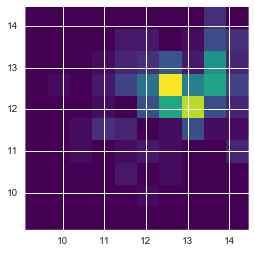

In [288]:
H, xedges, yedges = np.histogram2d(X.ix[100,:],Y.ix[200,:],bins)
plt.set_cmap('viridis')
im = plt.imshow(H, interpolation='none', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

In [329]:
def shannon_entropy(p):
    # Since p represents a discrete prob dist, check for floating point approximation to 1.0
    if not np.allclose(sum(p), 1.0): 
        raise Exception('Probabilities input to shannon entropy need to sum to 1')
    return - sum([x * np.log2(x) for x in p if x != 0])

In [331]:
hist, bins = np.histogram(X.ix[10,:],bins)
p = hist / float(sum(hist))
shannon_entropy(p)

3.1911352496071772

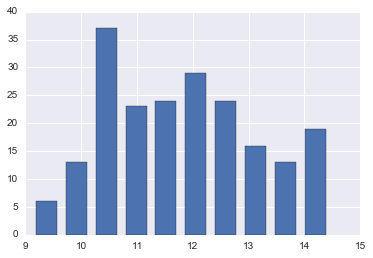

In [274]:
hist, bins = np.histogram(X.ix[10,:],bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [275]:
X.ix[10,:]

C30_2         9.7903
MG-0.1_1     13.1902
Oxctl_1      10.6324
S5_2         15.8104
M0t90_1      14.0864
S2_1         15.1012
GM+25_3      10.2234
LPhT_1       10.3248
Mt0_2        14.3229
GM+45_2       9.3054
MG+45_3      11.0327
Pyr_2        14.0451
Mt0_1.1      12.7951
LPhT_2       10.8298
GM-0.2_3     11.7326
dia5_3       11.8321
Paraq_2      10.7261
S7_6         14.7214
M9stat_3     14.2765
GM+60_1      10.7787
Paraq_1      10.1686
Fru_1        12.2754
MG+150_3     11.8827
S6_6         14.5826
Mt0_2        14.3229
nit_2        12.8678
MG+60_2      10.6797
HiOs_3       12.4754
S2_2         15.2231
M+G_3        11.4792
              ...   
G180_3        8.2253
SMMPr_1      12.5522
Diami_3       8.1099
MG+10_3      10.4849
GM+15_1      10.6824
MG+15_3      11.0300
LBGstat_2     8.4351
S3_3         14.1271
LPhT_3       11.0077
MG-0.2_2     12.7996
G+S_2        14.7203
M+G_2        11.2055
G135_3        7.7664
GM-0.1_2     11.8304
Mt0_3        13.0805
GM+10_3      10.2200
Oxctl_2      

In [246]:
calc_MI(np.array(X.transpose().as_matrix()), np.array(Y.transpose().as_matrix()), PARS['mi.bins'])

ValueError: could not broadcast input array from shape (269,239) into shape (269)

In [226]:
if len(X.index) > 6000:
    # speeds up MI calculation for large datasets
    # I actually don't know what this does, since X's rows are already filtered by 'tf.with.expr', 
    # which itself if a subset of IN['tf.names']
    X = X.ix[group_predictors['tf_names'], :] # This turn X into a TFs x Samples matrix, which is what I expected it to be

In [227]:
list(X.ix[tf_names, :].index)

['BSU31410',
 'BSU29740',
 'BSU27890',
 'BSU40800',
 'BSU37650',
 'BSU05370',
 'BSU21780',
 'BSU05700',
 'BSU39430',
 'BSU02970',
 'BSU13340',
 'BSU26350',
 'BSU03960',
 'BSU40410',
 'BSU05670',
 'BSU04160',
 'BSU07390',
 'BSU05170',
 'BSU25200',
 'BSU12510',
 'BSU13150',
 'BSU07590',
 'BSU03470',
 'BSU40670',
 'BSU08730',
 'BSU40710',
 'BSU38600',
 'BSU03170',
 'BSU03850',
 'BSU38880',
 'BSU33660',
 'BSU35200',
 'BSU15090',
 'BSU30150',
 'BSU27120',
 'BSU39990',
 'BSU09380',
 'BSU05180',
 'BSU34630',
 'BSU24520',
 'BSU37310',
 'BSU24610',
 'BSU01540',
 'BSU37550',
 'BSU22120',
 'BSU37620',
 'BSU33990',
 'BSU01690',
 'BSU03750',
 'BSU40540',
 'BSU40010',
 'BSU36300',
 'BSU08810',
 'BSU26580',
 'BSU29110',
 'BSU18760',
 'BSU10840',
 'BSU40130',
 'BSU00370',
 'BSU22440',
 'BSU17080',
 'BSU32560',
 'BSU11500',
 'BSU05060',
 'BSU05270',
 'BSU05320',
 'BSU09560',
 'BSU38450',
 'BSU08250',
 'BSU34180',
 'BSU25100',
 'BSU26870',
 'BSU12000',
 'BSU36600',
 'BSU13670',
 'BSU03880',
 'BSU05290',

In [210]:
tf_names

['BSU31410',
 'BSU29740',
 'BSU27890',
 'BSU40800',
 'BSU37650',
 'BSU05370',
 'BSU21780',
 'BSU05700',
 'BSU39430',
 'BSU02970',
 'BSU13340',
 'BSU26350',
 'BSU03960',
 'BSU40410',
 'BSU05670',
 'BSU04160',
 'BSU07390',
 'BSU05170',
 'BSU25200',
 'BSU12510',
 'BSU13150',
 'BSU07590',
 'BSU03470',
 'BSU40670',
 'BSU08730',
 'BSU40710',
 'BSU38600',
 'BSU03170',
 'BSU03850',
 'BSU38880',
 'BSU33660',
 'BSU35200',
 'BSU15090',
 'BSU30150',
 'BSU27120',
 'BSU39990',
 'BSU09380',
 'BSU05180',
 'BSU34630',
 'BSU24520',
 'BSU37310',
 'BSU24610',
 'BSU01540',
 'BSU37550',
 'BSU22120',
 'BSU37620',
 'BSU33990',
 'BSU01690',
 'BSU03750',
 'BSU40540',
 'BSU40010',
 'BSU36300',
 'BSU08810',
 'BSU26580',
 'BSU29110',
 'BSU18760',
 'BSU10840',
 'BSU40130',
 'BSU00370',
 'BSU22440',
 'BSU17080',
 'BSU32560',
 'BSU11500',
 'BSU05060',
 'BSU05270',
 'BSU05320',
 'BSU09560',
 'BSU38450',
 'BSU08250',
 'BSU34180',
 'BSU25100',
 'BSU26870',
 'BSU12000',
 'BSU36600',
 'BSU13670',
 'BSU03880',
 'BSU05290',

In [224]:
me = pandas.DataFrame({'condName': IN['exp.mat'].columns})

In [265]:
delt = IN['meta.data']['del.t']

In [269]:
prev = IN['meta.data']['prevCol']

In [266]:
delT_max = PARS['delT.max']

In [290]:
mismatched_condNames = IN['meta.data']['condName'][IN['meta.data']['condName'] != IN['exp.mat'].columns]

In [349]:
mismatched_condNames = meta_data['condName'][meta_data['condName'] != exp_mat.columns]

In [354]:
correct_col_names = list(exp_mat.columns[meta_data['condName'] != exp_mat.columns])

In [437]:
steady = prev.isnull() & (cond.isin(prev) != True)

In [444]:
res_matrix = pandas.DataFrame(exp_mat[cond[steady]])

In [448]:
des_matrix = pandas.DataFrame(exp_mat[cond[steady]]) + pandas.DataFrame(exp_mat[cond[steady != True]])

In [357]:
meta_data['condName'][meta_data['condName'] != exp_mat.columns] = correct_col_names

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [450]:
list(des_matrix.columns)

['B36_1',
 'B36_2',
 'B60_1',
 'B60_2',
 'BC/t_1',
 'BC/t_2',
 'BC_1',
 'BC_2',
 'BI_1',
 'BI_2',
 'BMM_1',
 'BMM_2',
 'BMM_3',
 'BT_1',
 'BT_2',
 'C30_1',
 'C30_2',
 'C90_1',
 'C90_2',
 'Cold_1',
 'Cold_2',
 'Cold_3',
 'Diami_1',
 'Diami_2',
 'Diami_3',
 'Etha_1',
 'Etha_2',
 'Etha_3',
 'Fru_1',
 'Fru_2',
 'Fru_3',
 'G+S_1',
 'G+S_2',
 'G+S_3',
 'G135_1',
 'G135_3',
 'G150_1',
 'G150_2',
 'G150_3',
 'G180_1',
 'G180_2',
 'G180_3',
 'GM+10_2',
 'GM+10_3',
 'GM+120_1',
 'GM+120_3',
 'GM+150_1',
 'GM+150_2',
 'GM+150_3',
 'GM+15_1',
 'GM+15_2',
 'GM+15_3',
 'GM+25_1',
 'GM+25_2',
 'GM+25_3',
 'GM+45_1',
 'GM+45_2',
 'GM+45_3',
 'GM+5_1',
 'GM+5_2',
 'GM+5_3',
 'GM+60_1',
 'GM+60_2',
 'GM+60_3',
 'GM+90_1',
 'GM+90_2',
 'GM+90_3',
 'GM-0.1_1',
 'GM-0.1_2',
 'GM-0.1_3',
 'GM-0.2_1',
 'GM-0.2_2',
 'GM-0.2_3',
 'Glu_1',
 'Glu_2',
 'Glu_3',
 'Glucon_1',
 'Glucon_2',
 'Glucon_3',
 'Gly_1',
 'Gly_2',
 'Gly_3',
 'H2O2_1',
 'H2O2_2',
 'H2O2_3',
 'HPh_1',
 'HPh_2',
 'HPh_3',
 'Heat_1',
 'Heat_2',


In [310]:
IN['exp.mat'].columns[IN['meta.data']['condName'] != IN['exp.mat'].columns]

Index([u'Mt0_1.1', u'Mt0_2.1', u'Mt0_3.1'], dtype='object')

In [319]:
IN['meta.data']['condName'][74:91]


74       SMM_3
75      Salt_3
76       Mt0_1
77     M0t45_1
78     M0t90_1
79       Mt0_2
80     M0t45_2
81     M0t90_2
82       Mt0_3
83     M0t45_3
84     M0t90_3
85       Mt0_1
86    M40t45_1
87    M40t90_1
88       Mt0_2
89    M40t45_2
90    M40t90_2
Name: condName, dtype: object

In [48]:
exp_mat_file = PARS['exp.mat.file']

In [312]:
other = pandas.read_csv(os.path.join(input_dir, exp_mat_file), header=0, sep='\t')

In [55]:
list(set(pandas.read_csv(os.path.join(input_dir, tf_names_file), header=None)[0]))

['BSU31410',
 'BSU29740',
 'BSU27890',
 'BSU40800',
 'BSU37650',
 'BSU05370',
 'BSU21780',
 'BSU05700',
 'BSU39430',
 'BSU02970',
 'BSU13340',
 'BSU26350',
 'BSU03960',
 'BSU40410',
 'BSU05670',
 'BSU04160',
 'BSU07390',
 'BSU05170',
 'BSU25200',
 'BSU12510',
 'BSU13150',
 'BSU07590',
 'BSU03470',
 'BSU40670',
 'BSU08730',
 'BSU40710',
 'BSU38600',
 'BSU03170',
 'BSU03850',
 'BSU38880',
 'BSU33660',
 'BSU35200',
 'BSU15090',
 'BSU30150',
 'BSU27120',
 'BSU39990',
 'BSU09380',
 'BSU05180',
 'BSU34630',
 'BSU24520',
 'BSU37310',
 'BSU24610',
 'BSU01540',
 'BSU37550',
 'BSU22120',
 'BSU37620',
 'BSU33990',
 'BSU01690',
 'BSU03750',
 'BSU40540',
 'BSU40010',
 'BSU36300',
 'BSU08810',
 'BSU26580',
 'BSU29110',
 'BSU18760',
 'BSU10840',
 'BSU40130',
 'BSU00370',
 'BSU22440',
 'BSU17080',
 'BSU32560',
 'BSU11500',
 'BSU05060',
 'BSU05270',
 'BSU05320',
 'BSU09560',
 'BSU38450',
 'BSU08250',
 'BSU34180',
 'BSU25100',
 'BSU26870',
 'BSU12000',
 'BSU36600',
 'BSU13670',
 'BSU03880',
 'BSU05290',

In [58]:
IN['exp.mat'] = pandas.read_csv(os.path.join(input_dir, exp_mat_file), header=0, sep='\t')

In [65]:
IN['exp.mat'][[0]].rows

AttributeError: 'DataFrame' object has no attribute 'rows'

In [72]:
IN['tf.with.expr'] = intersect(IN['tf.names'], IN['exp.mat'].index)

In [71]:
IN['tf.names'] = list(set(pandas.read_csv(os.path.join(input_dir, tf_names_file), header=None)[0]))

In [74]:
len(IN['tf.with.expr'])

239

In [382]:
prev = meta_data['prevCol']